In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from albumentations import RandomRotate90, VerticalFlip, HorizontalFlip, Compose, Normalize
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchmetrics import ConfusionMatrix
from tqdm import tqdm

torch.__version__

c:\Users\enoch\.conda\envs\deeplearn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W1023 23:38:38.071000 19348 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


'2.8.0+cu129'

In [2]:
import torch

if torch.cuda.is_available():
    print(torch.cuda.memory_summary(device=None, abbreviated=False))
else:
    print("CUDA is not available. Cannot check GPU memory.")

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [3]:
DATASET_PATH = "../dataset"
LABELS = ["Haze", "Normal", "Smoke"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DEVICE

device(type='cuda')

In [4]:
def show_transformed_image(img):
    # undo the normalization for display
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

Image shape: torch.Size([3, 256, 256])
Pixel range: [-2.1179039478302-2.6399998664855957]


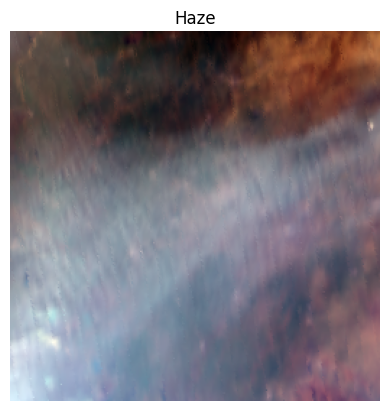

In [5]:
train_transform = Compose([
    RandomRotate90(),
    HorizontalFlip(),
    VerticalFlip(),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

test_transform = Compose([
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_dset = ImageFolder(os.path.join(DATASET_PATH, "train"), transform=lambda x: train_transform(image=np.array(x))['image'])
test_dset = ImageFolder(os.path.join(DATASET_PATH, "test"), transform=lambda x: test_transform(image=np.array(x))['image'])

image, label_index = train_dset[0]
test_image, test_label_index = test_dset[0]
print("Image shape:", image.shape)
print(f"Pixel range: [{image.min()}-{image.max()}]")

# (H, W, C) for matplotlib
plt.title(LABELS[label_index]) #train_dset.class_to_idx -> {'haze': 0, 'normal': 1, 'smoke': 2}
show_transformed_image(image)

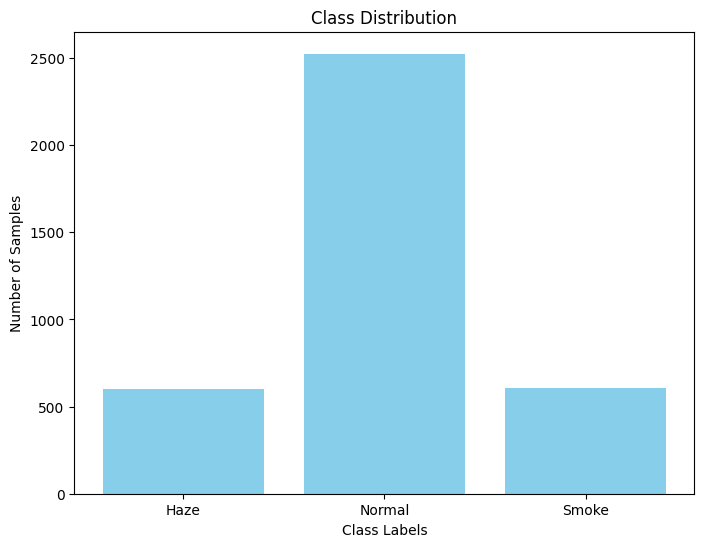

In [6]:
def plot_class_distribution(dataset, labels):
    class_counts = [0] * len(labels)
    for _, label in dataset:
        class_counts[label] += 1

    plt.figure(figsize=(8, 6))
    plt.bar(labels, class_counts, color='skyblue')
    plt.xlabel("Class Labels")
    plt.ylabel("Number of Samples")
    plt.title("Class Distribution")
    plt.show()

# Example usage:
plot_class_distribution(train_dset, LABELS)

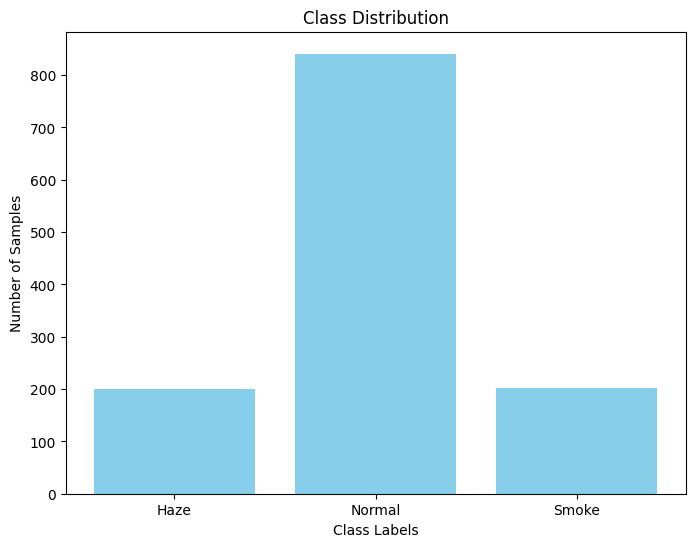

In [7]:
plot_class_distribution(test_dset, LABELS)

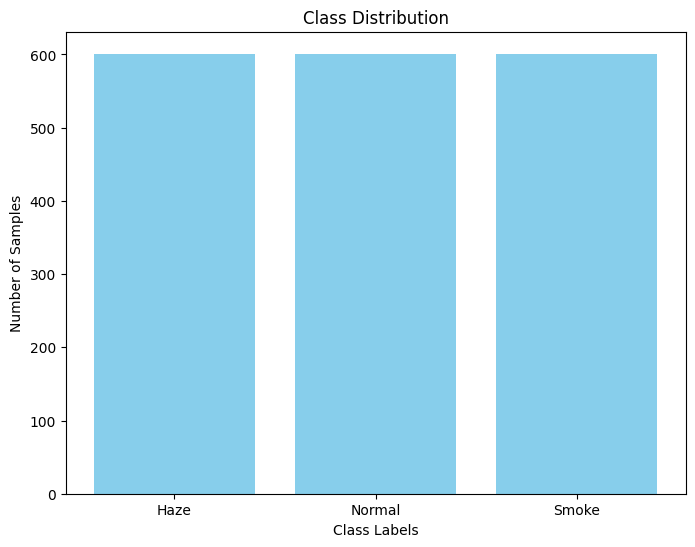

In [8]:
# undersampling of dataset to balance classes
def undersample_dataset(dataset):
    class_indices = {}
    for idx, (_, label) in enumerate(dataset):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(idx)

    min_class_size = min(len(indices) for indices in class_indices.values())

    balanced_indices = []
    for indices in class_indices.values():
        balanced_indices.extend(indices[:min_class_size])

    balanced_dataset = torch.utils.data.Subset(dataset, balanced_indices)
    return balanced_dataset

balanced_train_dset = undersample_dataset(train_dset)
plot_class_distribution(balanced_train_dset, LABELS)

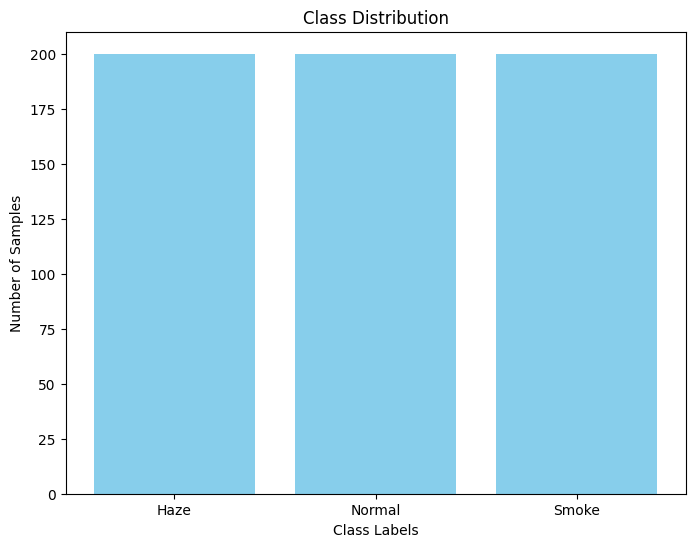

In [9]:
balanced_test_dset = undersample_dataset(test_dset)
plot_class_distribution(balanced_test_dset, LABELS)

In [10]:
from basic_cnn import BasicCNN

cnn = BasicCNN()
x = torch.randn(1, 3, 256, 256)
print(cnn(x).shape)

torch.Size([1, 3])


In [11]:
"""Basic from scratch CNN"""
class BasicCNNModule(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, **kwargs)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.maxpool(x)
        return self.relu(x)
    

class BasicCNN(nn.Module):
    def __init__(self, in_channels=3, hdim=64, num_classes=3, input_size=256):
        super().__init__()
        # 5 layers of conv with downsampling each spatial dimension by factor of 1/2 while
        # doubling the channels
        self.conv_modules = nn.ModuleList(
            [BasicCNNModule(in_channels=in_channels, out_channels=hdim, kernel_size=3, stride=1, padding=1)]
            + [BasicCNNModule(
                in_channels=hdim * (2**i), 
                out_channels=hdim * (2**(i+1)), 
                kernel_size=3, 
                stride=1, 
                padding=1) for i in range(4)
            ]
        )
        final_features = int((input_size * input_size) * hdim * (2 ** 4) / (2 ** 10))
        self.flatten = nn.Flatten(start_dim=1)
        self.linear = nn.Linear(in_features=final_features, out_features=num_classes)

    def forward(self, x):
        for module in self.conv_modules:
            x = module(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

"""Fine tuning pretrained models from torchvision"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as tvm
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# ----- VGG16Tuned ---------------------------------------------------------
class VGG16Tuned(nn.Module):
    """VGG16 edited for 3-class haze classification."""
    def __init__(self, num_classes=3, pretrained=True, freeze_features=True):
        super().__init__()
        base = tvm.vgg16(weights=tvm.VGG16_Weights.IMAGENET1K_V1 if pretrained else None)
        if freeze_features:
            for p in base.features.parameters(): p.requires_grad = False
        # replace classifier output
        in_f = base.classifier[-1].in_features
        base.classifier[-1] = SimpleMLP(input_size=in_f, hidden_size=4096, output_size=num_classes)
        self.trainable_model = base.classifier[-1]
        self.model = base
    def forward(self, x):
        return self.model(x)
    
    def save_weights(self, path):
        torch.save(self.model.classifier[-1].state_dict(), path)

    def load_weights(self, path, DEVICE="cpu"):
        self.model.classifier[-1].load_state_dict(torch.load(path, map_location=DEVICE))
    
# ----- ResNetTuned ---------------------------------------------------------
class ResNetTuned(nn.Module):
    """ResNet fine-tuned for 3-class haze/smoke/normal classification."""
    def __init__(self, num_classes=3, pretrained=True, freeze_features=True):
        super().__init__()
        base = tvm.resnet50(weights=tvm.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)

        # optionally freeze feature extractor
        if freeze_features:
            for p in base.parameters():
                p.requires_grad = False

        # replace the final fully-connected layer
        in_f = base.fc.in_features
        base.fc = SimpleMLP(input_size=in_f, hidden_size=4096, output_size=num_classes)
        self.trainable_model = base.fc
        self.model = base

    def forward(self, x):
        return self.model(x)
    
    def save_weights(self, path):
        torch.save(self.model.fc.state_dict(), path)

    def load_weights(self, path, DEVICE="cpu"):
        self.model.fc.load_state_dict(torch.load(path, map_location=DEVICE))
    
for net in (BasicCNN(), VGG16Tuned(), ResNetTuned()):
    cnn = net
    x = torch.randn(1, 3, 256, 256)
    print(net.__class__.__name__, end=": ")
    print(cnn(x).shape)


BasicCNN: torch.Size([1, 3])
VGG16Tuned: torch.Size([1, 3])
ResNetTuned: torch.Size([1, 3])


In [12]:
"""Attention modules"""
#----- default settings -----------------------------------------------------
class ConvBNAct(nn.Module):
    def __init__(self, c_in, c_out, k=3, s=1, p=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(c_in, c_out, k, s, p, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.block(x)

# ----- Haze-Aware Enhancement (HAE) ----------------------------------------
class HAEHead(nn.Module):
    """Predicts a 1-channel haze transmission map and compresses to a 128-D vector."""
    def __init__(self, in_ch=3, width=32, out_dim=128):
        super().__init__()
        self.body = nn.Sequential(
            ConvBNAct(in_ch, width),
            ConvBNAct(width, width),
            nn.Conv2d(width, 1, 1)
        )
        self.proj = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, out_dim))
    def forward(self, x):
        t = torch.sigmoid(self.body(x))                # transmission map
        pooled = F.adaptive_avg_pool2d(t, 1).view(x.size(0), 1)
        vec = self.proj(pooled)
        return vec, t

# ----- Dual-View Texture ----------------------------------------------------
class EdgeExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        sobel_x = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]],dtype=torch.float32)
        sobel_y = sobel_x.t()
        lap = torch.tensor([[0,1,0],[1,-4,1],[0,1,0]],dtype=torch.float32)
        self.register_buffer("kx", sobel_x[None,None])
        self.register_buffer("ky", sobel_y[None,None])
        self.register_buffer("kl", lap[None,None])
    @torch.no_grad()
    def forward(self, rgb):
        r,g,b = rgb[:,0:1], rgb[:,1:2], rgb[:,2:3]
        gray = 0.2989*r + 0.587*g + 0.114*b
        ex = F.conv2d(gray, self.kx, padding=1)
        ey = F.conv2d(gray, self.ky, padding=1)
        el = F.conv2d(gray, self.kl, padding=1)
        e = torch.cat([ex,ey,el],1)
        e = e/(e.abs().amax((2,3),keepdim=True)+1e-6)
        return e

class TextureHead(nn.Module):
    """Extracts structural cues from Sobel/Laplacian edge maps → 128-D vector."""
    def __init__(self, width=32, out_dim=128):
        super().__init__()
        self.edge = EdgeExtractor()
        self.fe = nn.Sequential(
            ConvBNAct(3,width),
            ConvBNAct(width,width*2),
            ConvBNAct(width*2,width*2)
        )
        self.proj = nn.Sequential(nn.Linear(width*2,out_dim), nn.ReLU(True))
    def forward(self, x):
        e = self.edge(x)
        f = self.fe(e)
        g = F.adaptive_avg_pool2d(f,1).flatten(1)
        vec = self.proj(g)
        return vec, e

# sanity
hae = HAEHead(); tex = TextureHead()
x = torch.randn(2,3,224,224)
v1,tmap = hae(x); v2,e = tex(x)
print("HAE vec/tmap:", v1.shape, tmap.shape)
print("Texture vec/edges:", v2.shape, e.shape)

HAE vec/tmap: torch.Size([2, 128]) torch.Size([2, 1, 224, 224])
Texture vec/edges: torch.Size([2, 128]) torch.Size([2, 3, 224, 224])


In [13]:
"""Utils for model wrapping"""
# === Model Builder Wrapper ==================================================
import torch.nn as nn
import torch.nn.functional as F

class FusionClassifier(nn.Module):
    def __init__(self, dim_backbone, dim_hae=128, dim_tex=128, num_classes=3, p_drop=0.2):
        super().__init__()
        dim_in = dim_backbone + (dim_hae if dim_hae else 0) + (dim_tex if dim_tex else 0)
        self.mlp = nn.Sequential(
            nn.LayerNorm(dim_in),
            nn.Linear(dim_in, 512), nn.ReLU(True),
            nn.Dropout(p_drop),
            nn.Linear(512, num_classes)
        )
    def forward(self, f_b, f_h=None, f_t=None):
        feats = [f_b]
        if f_h is not None: feats.append(f_h)
        if f_t is not None: feats.append(f_t)
        return self.mlp(torch.cat(feats, dim=1))


class ModelWithHeads(nn.Module):
    """Generic wrapper that adds HAE/Texture heads to any backbone producing a feature vector."""
    def __init__(self, backbone, feature_dim, num_classes=3, use_hae=True, use_tex=True):
        super().__init__()
        self.backbone = backbone
        self.use_hae = use_hae
        self.use_tex = use_tex
        self.hae = HAEHead(out_dim=128) if use_hae else None
        self.tex = TextureHead(out_dim=128) if use_tex else None
        self.cls = FusionClassifier(feature_dim,
                                    dim_hae=128 if use_hae else 0,
                                    dim_tex=128 if use_tex else 0,
                                    num_classes=num_classes)

    def forward(self, x):
        f_b = self.backbone(x)
        if f_b.ndim > 2:  # if feature map, pool and flatten
            f_b = F.adaptive_avg_pool2d(f_b, 1).flatten(1)
        f_h = f_t = None
        if self.use_hae: f_h, _ = self.hae(x)
        if self.use_tex: f_t, _ = self.tex(x)
        logits = self.cls(f_b, f_h, f_t)
        return logits
    
def build_model(model_name="basiccnn", use_heads=False, num_classes=3,
                pretrained=True, freeze_features=True):
    """
    Returns a model by name, optionally with HAE/Texture heads attached.
    model_name: 'basiccnn', 'vgg16'
    """
    model_name = model_name.lower()

    # --- baseline backbones ---
    if model_name == "basiccnn":
        base = BasicCNN(in_channels=3, hdim=64, num_classes=num_classes, input_size=256)
        backbone = BasicCNN(in_channels=3, hdim=64, num_classes=num_classes, input_size=256)
        feature_dim = num_classes  # BasicCNN outputs logits directly

    elif model_name == "vgg16":
        base = VGG16Tuned(num_classes=num_classes, pretrained=pretrained, freeze_features=freeze_features)
        # expose pre-classifier features instead of logits
        backbone = nn.Sequential(base.model.features, base.model.avgpool, nn.Flatten(), *list(base.model.classifier.children())[:-1])
        feature_dim = 4096

    elif model_name == "resnet50":
        base = VGG16Tuned(num_classes=num_classes, pretrained=pretrained, freeze_features=freeze_features)
        # expose pre-classifier features instead of logits
        backbone = nn.Sequential(base.model.features, base.model.avgpool, nn.Flatten(), *list(base.model.classifier.children())[:-1])
        feature_dim = 4096

    else:
        raise ValueError("model_name must be one of: basiccnn, vgg16, resnet50")

    # --- wrap or return plain ---
    if use_heads:
        return ModelWithHeads(backbone, feature_dim, num_classes=num_classes,
                              use_hae=True, use_tex=True)
    else:
        return base


In [14]:
# plain backbones
CNNunmasked = build_model("basiccnn", use_heads=False)
VGG16unmasked = build_model("vgg16", use_heads=False)
ResNet50unmasked = build_model("resnet50", use_heads=False)

# augmented versions
CNNmasked = build_model("basiccnn", use_heads=True)
VGG16masked = build_model("vgg16", use_heads=True)
ResNet50masked = build_model("resnet50", use_heads=True)

# quick test
for name, model in [("basiccnn+heads", CNNmasked), ("vgg16+heads", VGG16masked), ("resnet50+heads", ResNet50masked)]:
    x = torch.randn(1,3,256,256)
    y = model(x)
    print(f"{name:15s} ->", tuple(y.shape))

for name, model in [("basiccnn", CNNunmasked), ("vgg16", VGG16unmasked), ("resnet50", ResNet50unmasked)]:
    x = torch.randn(1,3,256,256)
    y = model(x)
    print(f"{name:15s} ->", tuple(y.shape))


basiccnn+heads  -> (1, 3)
vgg16+heads     -> (1, 3)
resnet50+heads  -> (1, 3)
basiccnn        -> (1, 3)
vgg16           -> (1, 3)
resnet50        -> (1, 3)


In [15]:
train_loader = DataLoader(dataset=balanced_train_dset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=balanced_test_dset, batch_size=32, shuffle=False)

data_batch = next(iter(train_loader))
imgs, labels = data_batch
imgs.shape, labels.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

In [16]:
from traineval import train_model_epoch, test_model
cnn = BasicCNN()
cnn.load_state_dict(torch.load("saves/basic_cnn_model_undersampled_aug.pt", map_location=DEVICE))

loss, confmat, accuracy, precision, recall, f1_score = test_model(test_loader, cnn, DEVICE=DEVICE)
print("Confusion matrix:\n", confmat)
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1_score*100:.2f}%")

100%|██████████| 19/19 [00:00<00:00, 20.04it/s]

Confusion matrix:
 [[172   1  27]
 [  0 194   6]
 [ 27  10 163]]
Accuracy: 88.17%
Precision: 94.63%
Recall: 97.00%
F1 Score: 95.80%


In [17]:
LEARNING_RATE = 3e-4
NUM_EPOCHS = 100
model = build_model("vgg16", use_heads=False, freeze_features=True)
model.to(DEVICE)
# model.load_weights("saves/vgg16-noheads.pt")
# model.load_state_dict(torch.load("saves/basic_cnn_model_undersampled_aug.pt", map_location=DEVICE))
writer = SummaryWriter()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(params=model.trainable_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

In [18]:
torch.cuda.empty_cache()
for epoch in range(NUM_EPOCHS):
    train_model_epoch(train_loader, test_loader, model, criterion, optimizer, writer, DEVICE=DEVICE, epoch=epoch)

100%|██████████| 19/19 [00:02<00:00,  9.09it/s]


In [ ]:
model = build_model("resnet50", use_heads=True, freeze_features=False)
model.to(DEVICE)
model.load_state_dict(torch.load("saves/resnet50-withheads.pt", map_location=DEVICE))

<All keys matched successfully>

In [21]:
model = build_model("vgg16", use_heads=False, freeze_features=True)
model.to(DEVICE)
model.load_weights("saves/vgg16-noheadsMLP.pt")

In [19]:
model.save_weights("saves/vgg16-noheadsMLP.pt")

In [40]:
pretrained = tvm.vgg16(weights=tvm.VGG16_Weights.IMAGENET1K_V1).to(DEVICE)
for name, param in model.model.named_parameters():
    if "classifier.6" not in name:
        assert torch.equal(param.data, pretrained.state_dict()[name])

In [22]:
loss, confmat, accuracy, precision, recall, f1_score = test_model(test_loader, model, DEVICE=DEVICE)
print("Confusion matrix:\n", confmat)
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1_score*100:.2f}%")
#first row -> haze 
#second row -> normal
#third row -> smoke

# confusion matrix: format

# 1st row 1st column -> true haze predicted as haze
# 1st row 2nd column -> true haze predicted as normal
# 1st row 3rd column -> true haze predicted as smoke

100%|██████████| 19/19 [00:01<00:00, 10.46it/s]

Confusion matrix:
 [[181   5  14]
 [  3 178  19]
 [ 19  12 169]]
Accuracy: 88.00%
Precision: 91.28%
Recall: 89.00%
F1 Score: 90.13%


In [31]:
torch.save(model.state_dict(), "saves/resnet50-withheads.pt")

In [ ]:
# inf block

import sys, subprocess

# pick one
model_name = "resnet50"          # "basiccnn" | "vgg16" | "resnet50"
use_heads  = False               # True if you trained the +heads variant
weights    = "weights/resnet50_best.pth"
test_dir   = "evaluation/test_data"
out_csv    = "evaluation/output/sample_predictions.csv"

# optional: ground-truth CSV so 'actual_class' is filled with real labels
# leave as None if you don't have one for the test set
gt_csv = None  # e.g., "evaluation/test_labels.csv"

cmd = [
    sys.executable, "inference.py",
    "--model", model_name,
    "--weights", weights,
    "--test_dir", test_dir,
    "--out_csv", out_csv,
]
if use_heads:
    cmd.append("--use_heads")
if gt_csv:
    cmd += ["--gt_csv", gt_csv]

print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True)
print("Done. CSV at:", out_csv)
